In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPrediction_SelectingModel//Data/'

In [2]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

Cross Validation

In [3]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=6, test_size=365)
df = df.sort_index()

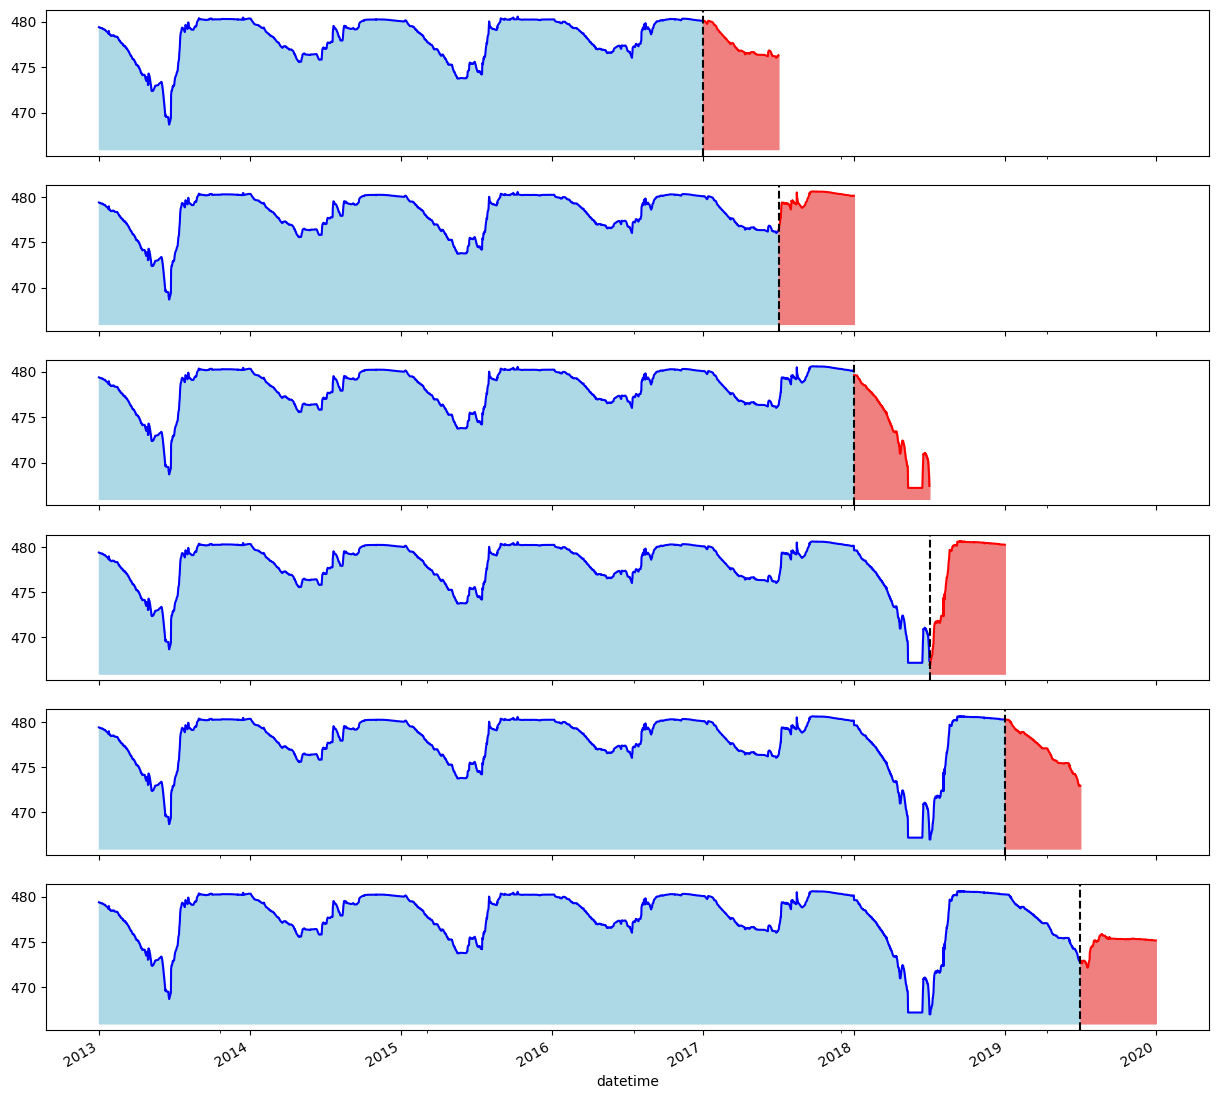

In [5]:
fig, axs = plt.subplots(6,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

Train the model with first features set

In [7]:
from sklearn.ensemble import RandomForestRegressor

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor(verbose=1,
                                    n_jobs=-1,
                                    oob_score=True)
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0

In [16]:
oob_error = 1 - rf_reg.oob_score_
print(f'Out-of-Bag Error (OOB): {oob_error}')

Out-of-Bag Error (OOB): 0.9476699642781007


Model Evaluation

In [17]:
print(f'root mean squared error across folds:{np.mean(rmses)}')
print(f'scores for each folds:{rmses}')

root mean squared error across folds:3.1952114031182037
scores for each folds:[1.9574785830671282, 1.5848176827778615, 6.333490956686252, 3.8299126506807357, 2.296914270496683, 3.16865427500056]


In [18]:
print(f'root mean squared error across folds:{np.mean(maes)}')
print(f'scores for each folds:{maes}')

root mean squared error across folds:2.6847719749688346
scores for each folds:[1.7089726409801131, 1.418126314431206, 4.8452060145478, 3.2015452351685343, 1.9379458365895346, 2.996835808095822]


In [19]:
print(f'r2 score across on train set:{np.mean(r2s)}')
print(f'scores for each folds:{r2s}')

r2 score across on train set:-2.8834037087188613
scores for each folds:[-1.0946973326396585, -3.003190032178283, -1.224373597899295, 0.04367704716804366, -0.3952946799821029, -11.626543656781875]


Create Lag Feature

In [4]:
def add_lag(df):
    target_map = df['water_level'].to_dict() # mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)# lag 12 hours
    return df

df = add_lag(df)
df = df.dropna(subset=['lag'])# drop the NaN value because model won't accept it
df.head()

,year,month,day,water_level,hour,precipitation,sluice_status,lag
datetime,,,,,,,,
2013-01-01 19:00:00,2013,1,1,479.38,19,0.0,0,479.40
2013-01-02 07:00:00,2013,1,2,479.37,7,0.0,5,479.38
2013-01-02 19:00:00,2013,1,2,479.36,19,0.0,5,479.37
2013-01-03 07:00:00,2013,1,3,479.36,7,0.0,5,479.36
2013-01-03 19:00:00,2013,1,3,479.36,19,0.0,5,479.36


Retrain the model with second feature set

In [9]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status', 'lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor(verbose=1,
                                    n_jobs=-1,
                                    oob_score=True)
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0

In [22]:
print(f'root mean squared error across folds:{np.mean(rmses)}')
print(f'scores for each folds:{rmses}')

root mean squared error across folds:0.2345505880984
scores for each folds:[0.05171298059649758, 0.16056508587627827, 0.8051427638489262, 0.21635866702928266, 0.09677371946396832, 0.07675031177544667]


In [23]:
print(f'root mean squared error across folds:{np.mean(maes)}')
print(f'scores for each folds:{maes}')

root mean squared error across folds:0.12707894165301611
scores for each folds:[0.032653623093685774, 0.10851684609690687, 0.41365794468013284, 0.11506539717197686, 0.04585465770512889, 0.046725181170265626]


In [24]:
print(f'r2 score across on train set:{np.mean(r2s)}')
print(f'scores for each folds:{r2s}')

r2 score across on train set:0.9847604603192291
scores for each folds:[0.9985380706620932, 0.9589087056038301, 0.9640526226794744, 0.9969480639053804, 0.9975231983232109, 0.9925921007413857]


Hyperparameter Tuning

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=tss)
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parall

Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [27]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [28]:

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    rf_reg = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'],
                                   max_features=best_params['max_features'],
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   min_samples_split=best_params['min_samples_split'],
                                   n_jobs=-1,
                                   oob_score=True
                                   )
    rf_reg.fit(X_train, y_train)
    
    y_pred = rf_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

In [29]:
oob_error = 1 - rf_reg.oob_score_
print(f'Out-of-Bag Error (OOB): {oob_error}')

Out-of-Bag Error (OOB): 0.0014776303432497695


In [30]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')

mean squared error across fold:0.23621309322737402
score for each fold:[0.04114140689029421, 0.1562294401604172, 0.8595290923509, 0.22424331495678942, 0.07067349308706466, 0.06546181191877852]


In [31]:
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')

mean absolute error across fold:0.13012054804030507
score for each fold:[0.02909375088506827, 0.10466271559824139, 0.43879262973654265, 0.12621239724195743, 0.03943456969757724, 0.04252722508244354]


In [32]:
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

r2 score across fold:0.9848693918407504
score for each fold:[0.999074693699429, 0.9610978733746077, 0.9590322055719752, 0.9967215704834196, 0.9986790405665427, 0.9946109673485284]


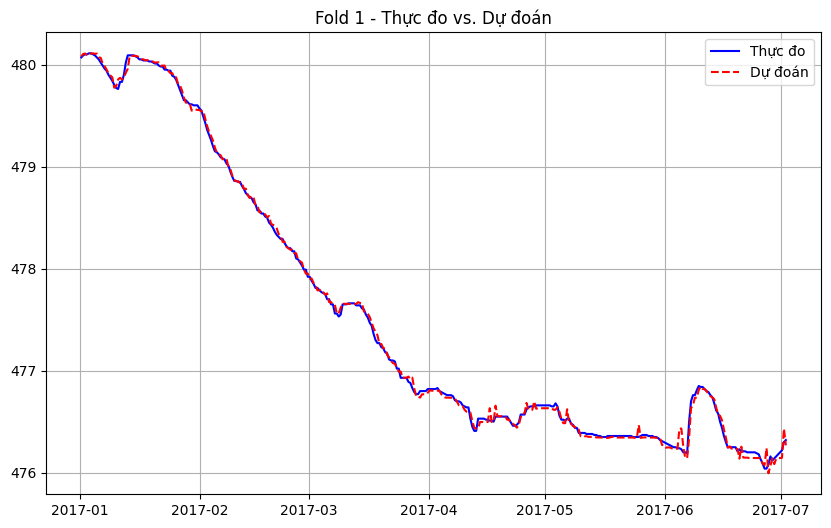

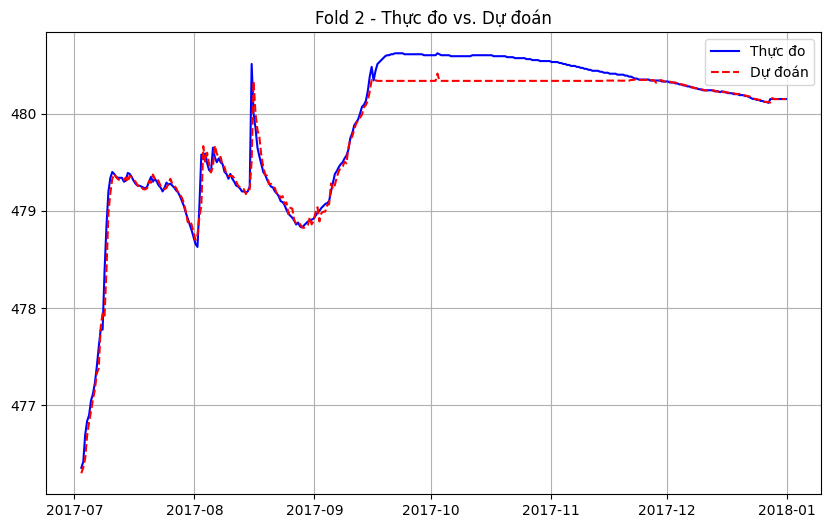

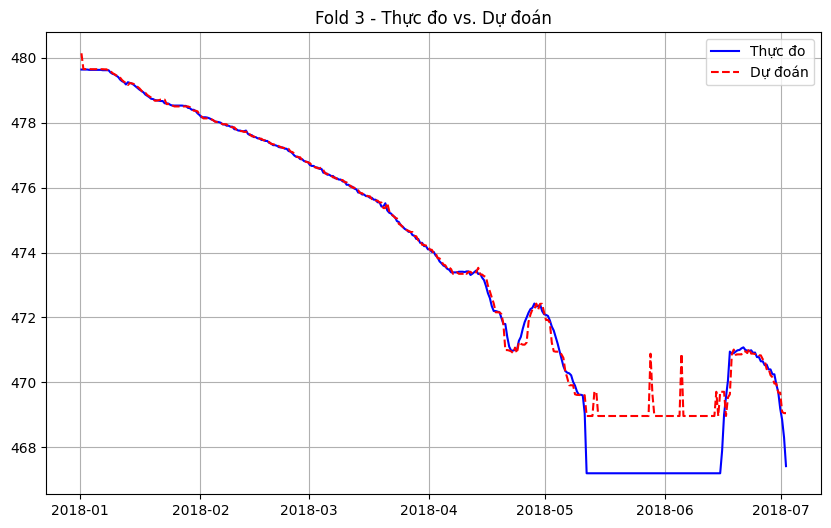

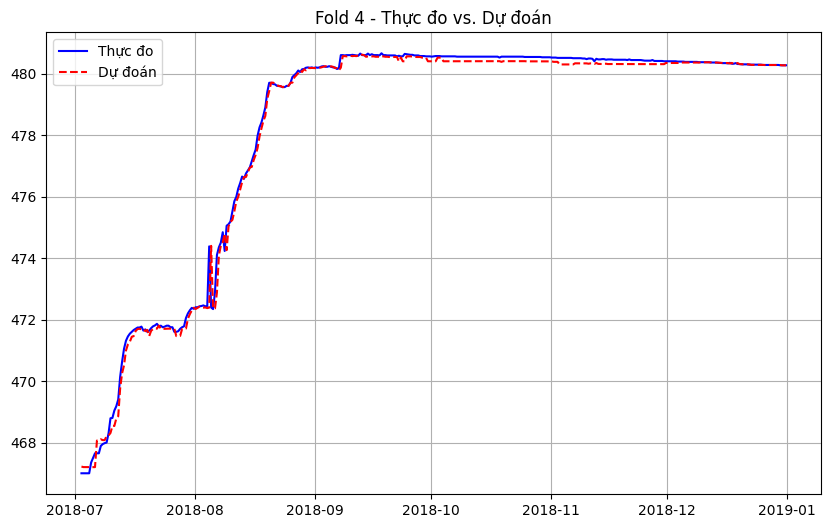

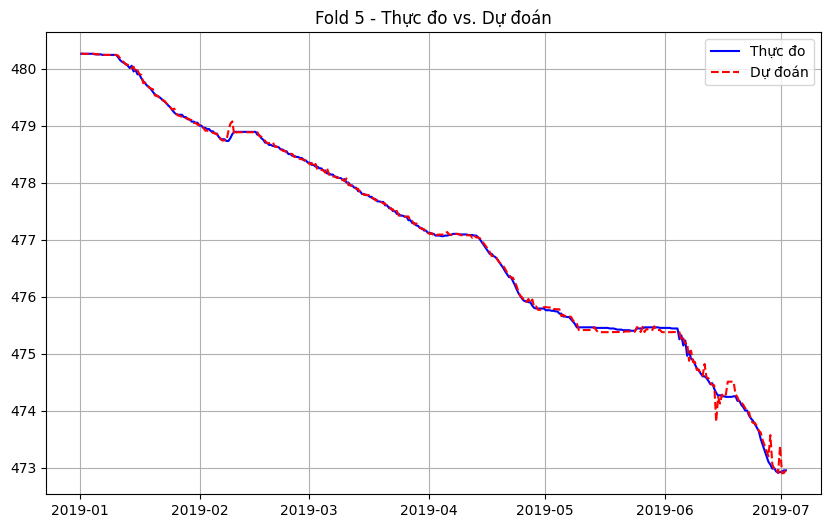

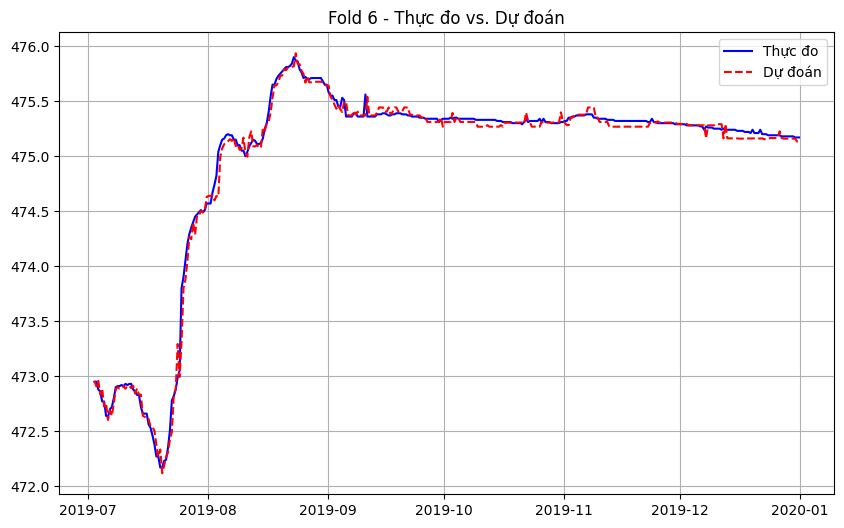

In [33]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()

Save the model for Deployment

In [9]:
import joblib
rf_reg_file = 'rf_regression.joblib'
joblib.dump(rf_reg, rf_reg_file)

['rf_regression.joblib']

In [10]:
input_data = [[27,0,471.8],[49,0,472.35],[26,0,473.15]]

input_df = pd.DataFrame(input_data)

predictions = rf_reg.predict(input_df)

# Round the predictions to 2 decimal places
predictions = [round(pred, 2) for pred in predictions]

print(predictions)

[471.95, 472.7, 473.24]


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
